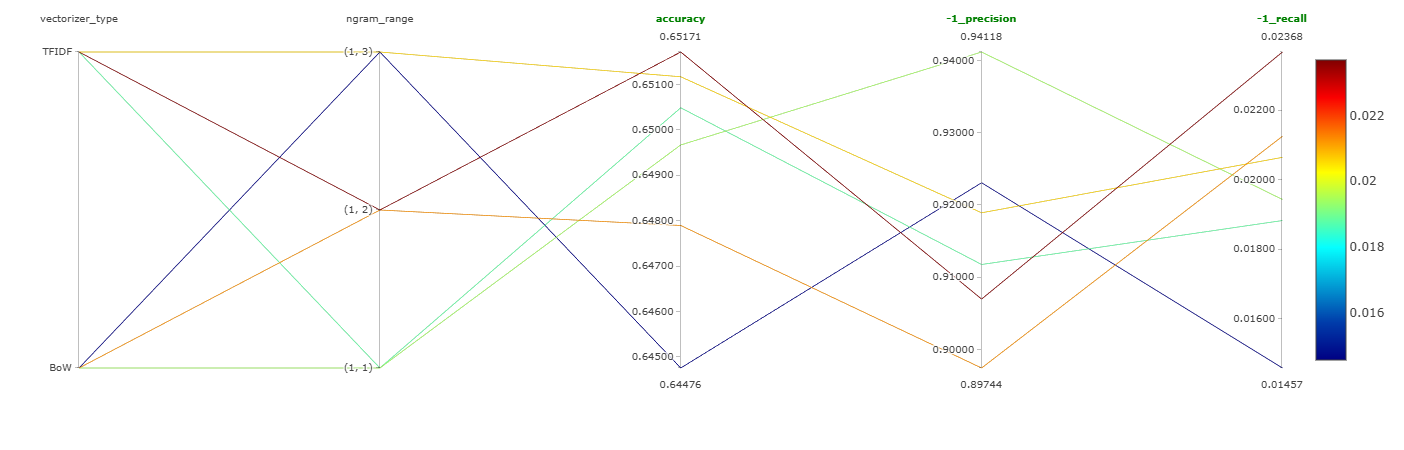

1. Analysis:
* From the experiment 1 the negative comments had low precision and low recall.
* When used Vectorization with BoW(Bag o Words) and TF-IDF with ngram values uni,bi and tri and max features of 5000 the result is shown from the above diangram
2. Results:
* From the above diagram i had to watch for Negative comments and took the features and Vectors which showed high recall and high precision.
* After observation i am selecting bigram with TF-IDF.
3. Further Work:
* Now i am using values to find the best max features for the Vectorizer.



In [ ]:
!pip install mlflow boto3 awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.0/677.0 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!aws configure

In [ ]:
import mlflow
mlflow.set_tracking_uri('http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/')
mlflow.set_experiment('Experiment-3 TF-IDF Bigram')

2025/07/26 11:43:11 INFO mlflow.tracking.fluent: Experiment with name 'Experiment-3 TF-IDF Bigram' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-26072025/192686273728971979', creation_time=1753530191516, experiment_id='192686273728971979', last_update_time=1753530191516, lifecycle_stage='active', name='Experiment-3 TF-IDF Bigram', tags={}>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow.sklearn
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


In [ ]:
df=pd.read_csv('/content/reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [ ]:
def run_experiment_to_find_max_features(vectorized_max_features):
  ngram_range=(1,2)
  vectorizer=TfidfVectorizer(ngram_range=ngram_range,max_features=vectorized_max_features)
  X_train,X_test,y_train,y_test=train_test_split(df['clean_comment'],df['category'],test_size=0.2,random_state=42,stratify=df['category'])
  X_train_vectorized=vectorizer.fit_transform(X_train)
  X_test_vectorized=vectorizer.transform(X_test)

  with mlflow.start_run():
    mlflow.set_tags({
        "mlflow.runName": f"TF-IDF_Bigram_maxFeatures{vectorized_max_features}",
        "experiment_type": "Feature Engineering",
        "model_type": "RandomForestClassifier",
        "description": f"Random Forest with TF-IDF,Bi-grams,max-Features_{vectorized_max_features}"
    })

    n_estimator=200
    max_depth=15

    mlflow.log_params({
        "vectorizer_type": "TF-IDF",
        "ngram_range": ngram_range,
        "vectorizer_max_features": vectorized_max_features,
        "n_estimators": n_estimator,
        "max_depth": max_depth
    })

    model=RandomForestClassifier(n_estimators=n_estimator,max_depth=max_depth)
    model.fit(X_train_vectorized,y_train)

    y_pred=model.predict(X_test_vectorized)

    accuracy=accuracy_score(y_test,y_pred)
    mlflow.log_metric("accuracy",accuracy)

    classification_rept=classification_report(y_test,y_pred,output_dict=True)
    for label,metrics in classification_rept.items():
      if isinstance(metrics,dict):
        for metric_name,metric_value in metrics.items():
          mlflow.log_metric(f"{label}_{metric_name}",metric_value)

    confusion_mtx=confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_mtx,annot=True,fmt='d',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    mlflow.log_artifact('confusion_matrix.png')

    mlflow.sklearn.log_model(model,"model")

2025/07/26 12:04:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:04:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures1000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/457ad7a5e9cd434b826ef116cc5edb6a
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:05:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:05:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures2000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/9fe73af1aef744188f18b690c684f8bc
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:06:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:06:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures3000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/db7008dc73ae47bb8d8feecfda9def46
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:07:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:07:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures4000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/55191cb86a694d8881210e46a1941cd5
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:08:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:08:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures5000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/f99c5bf162e54137b97b781abc7e0535
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:09:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:09:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures6000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/8eff0865b7634ca8a9c64463a0316cc1
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:10:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:10:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures7000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/e6d49327660e41bda9350ed40cbf3b24
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:11:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:11:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures8000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/b8f3ee23e5644f36ae5a2c75f0955f4f
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:12:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:12:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures9000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/21ea7b486eb24d789ae919f24302716b
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


2025/07/26 12:13:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 12:13:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_Bigram_maxFeatures10000 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979/runs/ee699039ad3d458b875b82dad54b02be
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/192686273728971979


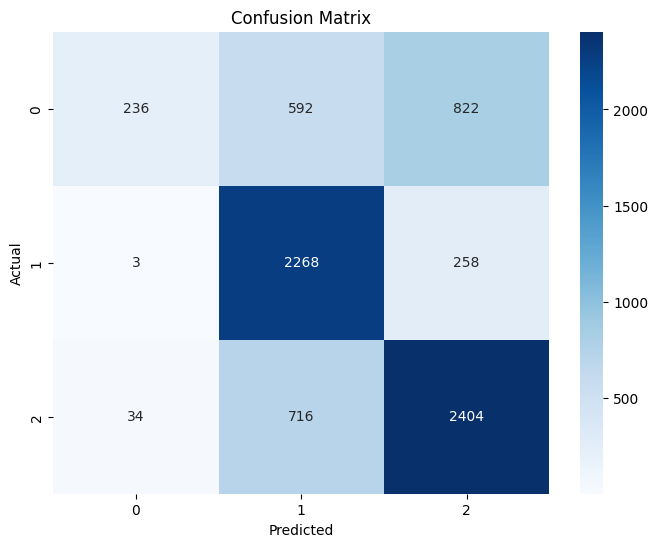

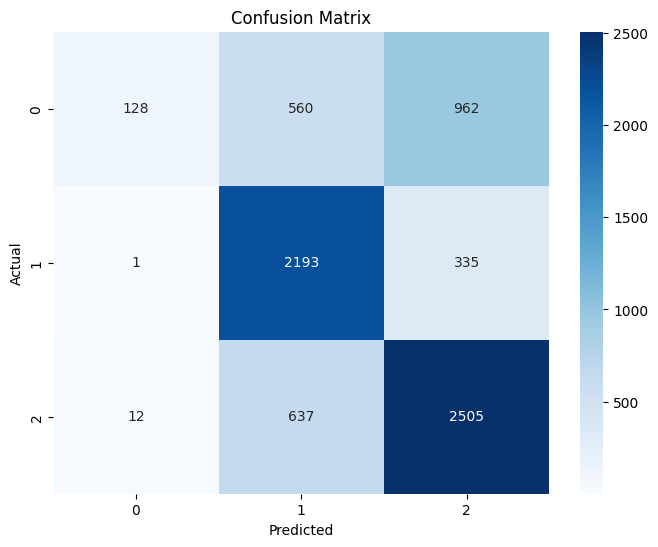

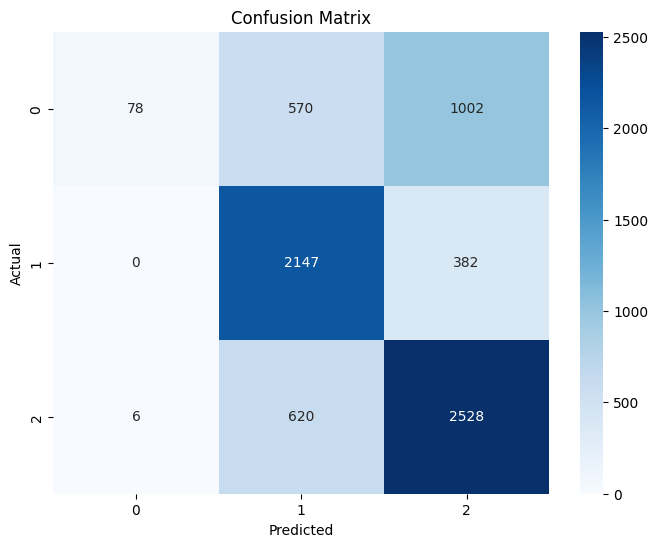

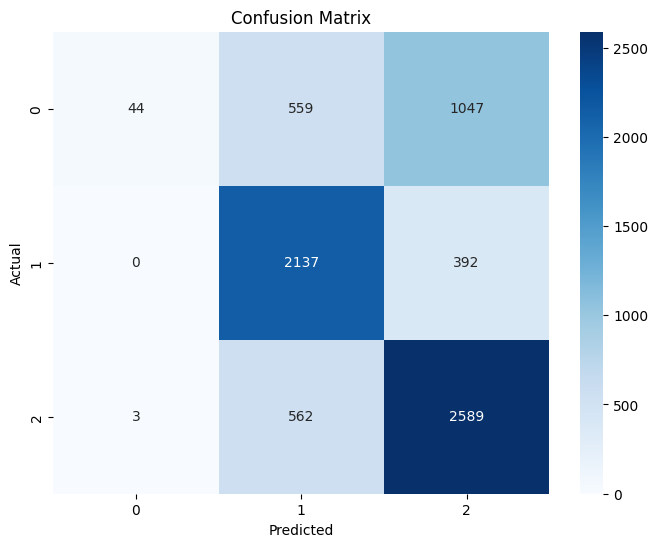

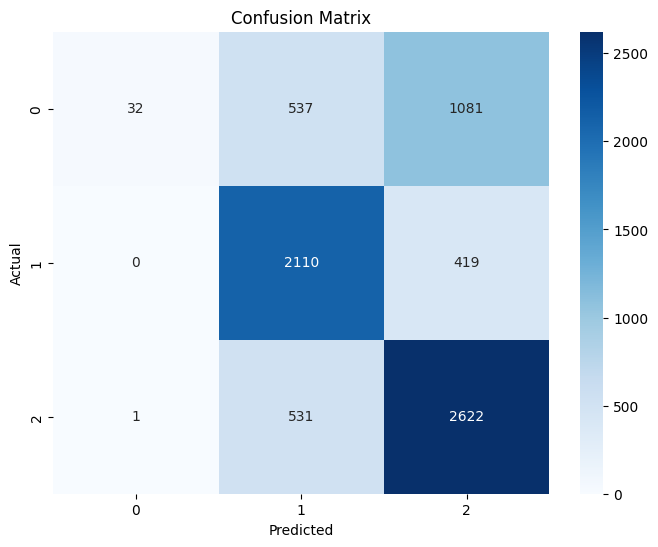

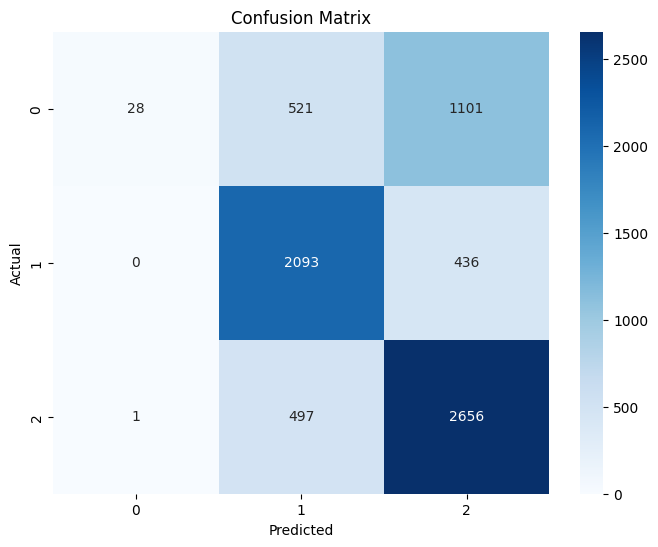

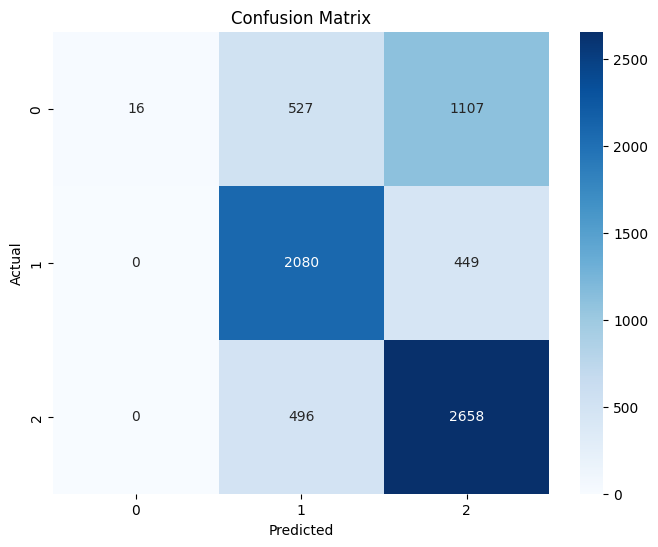

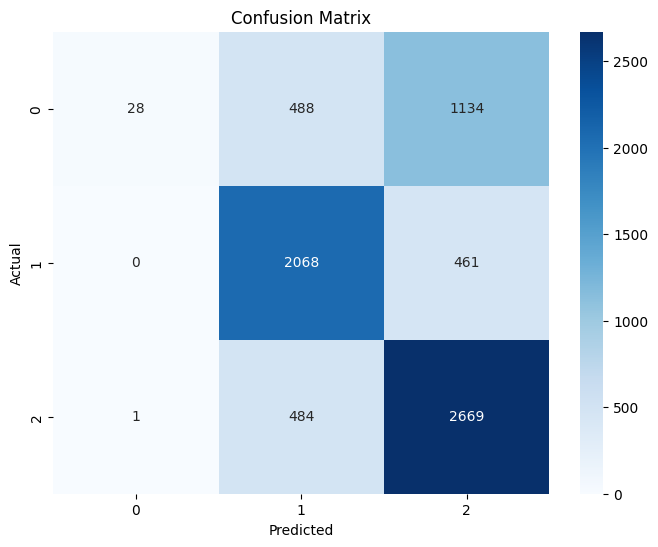

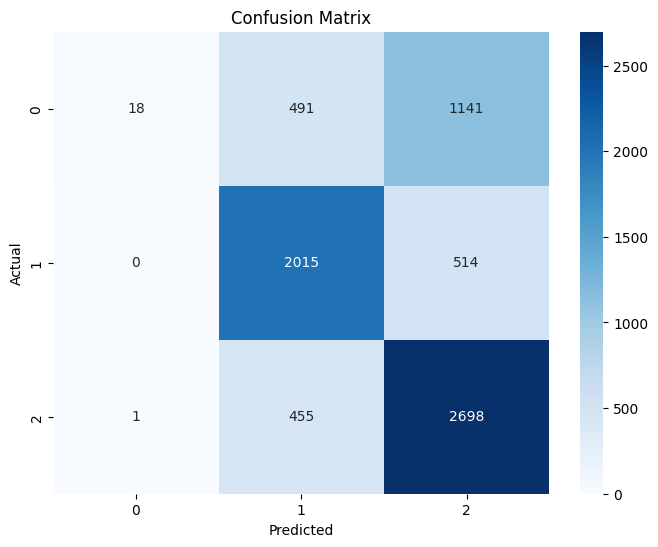

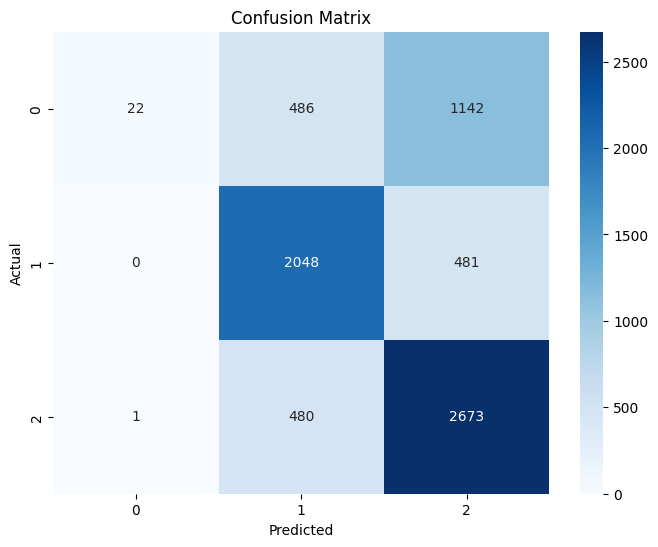

In [ ]:
max_feature_values=[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
for max_features in max_feature_values:
  run_experiment_to_find_max_features(max_features)